In [ ]:
import pandas as pd
import pickle
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [2]:
def read_dataframe(filename):
    if filename.endswith(".csv"):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    elif filename.endswith(".parquet"):
        df = pd.read_parquet(filename)

    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)

    return df

In [3]:
df_train = read_dataframe("../data/green_tripdata_2021-01.parquet")
df_val = read_dataframe("../data/green_tripdata_2021-02.parquet")

In [4]:
df_train["PU_DO"] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]

In [5]:
categorical = ["PU_DO"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [6]:
y_train = df_train["duration"].values
y_val = df_val["duration"].values

In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.4793657829373155

In [9]:
with open("models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)

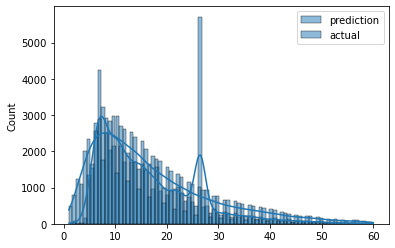

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(y_pred, kde=True, label="prediction")
sns.histplot(y_train, kde=True, label="actual")

plt.legend()
plt.show()